# Generating Weak Labels for Images

In this notebook, we write labeling functions over a set of unlabeled images to create a weakly-labeled dataset for **people riding bikes**. 

In doing so, we follow: 
1. **Load and visualize dataset** — what priors do we have about our data to build intuition about our task? 
2. **Generate Primitives** — how can we structure low-level _primitives_ that capture our priors? 
3. **Write Labeling Functions** — how do we formalize our heuristics into labeling functions over our user-defined primitives?
4. **Generate Training Set** — how can we aggregate our heuristic-based lableing functions to create a training set using the Snorkel paradigm?

The approach we show in this notebook takes advantage of very basic primitives and models the generative structure of the data in a very straightforward way. There's a lot of room to experiment here — for more, see recent work that incorporates static analysis + primitive dependencies to infer generative structure: [Varma et. al 2017](https://arxiv.org/abs/1709.02477).

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

**Note**: In this tutorial, we use `scikit-image`. If you don't already have it installed, please run the following cell.

In [2]:
import sys
!{sys.executable} -m pip install scikit-image

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

## 1. Load and Visualize Dataset
First, we load the dataset and associated bounding box objects and labels for people riding bikes.

In [4]:
from data_loader import DataLoader
loader = DataLoader()

We can visualize some **positive examples** of people riding bikes...

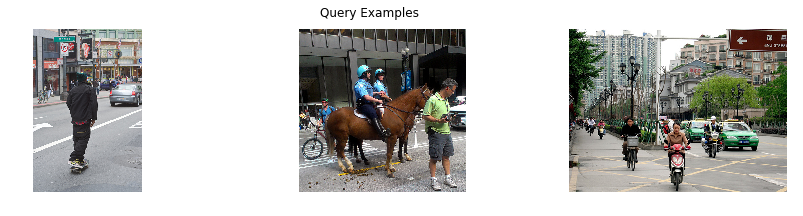

In [5]:
loader.show_examples(annotated=False, label=1)

...and some **negative** examples.

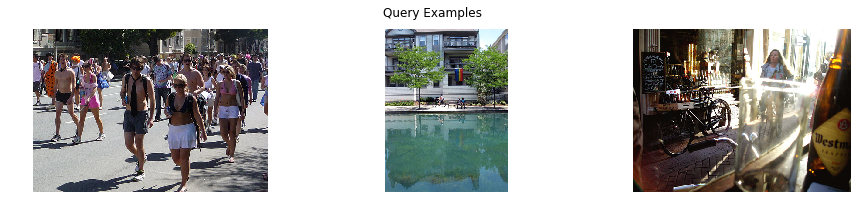

In [6]:
loader.show_examples(annotated=False, label=-1)

## 2. Generate Primitives
We write labeling functions (LFs) over _primitives_, instead of raw pixel values, becaues they are practical and interpretable.

In this case, we extract object bounding boxes using off-the-shelf tools and use the labels, positions, and sizes of each object as simple _primitives_. Then, we can also combine them into more complex _primitives_, as seen in `primitive_helpers.py`.

**Keep in mind**, we generate very simple primitives using off-the-shelf methods in this example. However, there is certainly a lot of room for development and exploration at this step!

#### Membership-based Primitives
These _primitives_ check whether certain objects appear in the images.

In [7]:
def has_bike(object_names):
    if ('cycle' in object_names) or ('bike' in object_names) or ('bicycle' in object_names):
        return 1
    else:
        return 0

In [8]:
def has_human(object_names):
    if (('person' in object_names) or ('woman' in object_names) or ('man' in object_names)) \
        and (('bicycle' in object_names) or 'bicycles' in object_names):
        return 1
    else:
        return 0

In [9]:
def has_road(object_names):
    if ('road' in object_names) or ('street' in object_names) or ('concrete' in object_names):
        return 1
    else:
        return 0

In [10]:
def has_cars(object_names):
    if ('car' in object_names) or ('cars' in object_names) or \
        ('bus' in object_names) or ('buses' in object_names) or \
        ('truck' in object_names) or ('trucks' in object_names):
        return 1
    else:
        return 0

#### Object Relationship Based Primitives
These _primitives_ look at the relations among bikes and people in the images. They capture the relative:
* number of bikes vs people
* position of bikes vs people
* size of bikes vs people

The code for these _primitives_ can be found `primitive_helpers.py`.

In [11]:
from primitive_helpers import PrimitiveObject, bike_human_nums, bike_human_distance, bike_human_size

def create_primitives(loader):
    m = 7
    primitive_mtx = np.zeros((loader.train_num,m))

    for i in range(loader.train_num):
        primitive_mtx[i,0] = has_human(loader.train_object_names[i])
        primitive_mtx[i,1] = has_road(loader.train_object_names[i])
        primitive_mtx[i,2] = has_cars(loader.train_object_names[i])
        primitive_mtx[i,3] = has_bike(loader.train_object_names[i])

        primitive_mtx[i,4] = bike_human_distance(loader.train_object_names[i], 
                                                 loader.train_object_x[i], 
                                                 loader.train_object_y[i])

        area = np.multiply(loader.train_object_height[i], loader.train_object_width[i])
        primitive_mtx[i,5] = bike_human_size(loader.train_object_names[i], area)
        primitive_mtx[i,6] = bike_human_nums(loader.train_object_names[i])
        
    P = PrimitiveObject()
    P.save_primitive_matrix(primitive_mtx)
    return P

**Assign and Name Primitives**
We assign the primitives and name them according to the variables we will use to refer to them in the labeling functions we develop next. 

For example, `primitive_mtx[i,0]` is referred to as `has_human`.

In [12]:
P = create_primitives(loader)
primitive_names = ['has_human', 'has_road', 'has_cars', 'has_bike', 
                   'bike_human_distance', 'bike_human_size', 'bike_human_num']

## 3. Write Labeling Functions (LFs)
We now develop LFs that take different primitives in as inputs and apply a label based on the value of those primitives. Notice that each of these LFs are "weak" -- they aren't fully precise, and they don't have complete coverage. 

Below, we have incldue the intuition that explains each of the LFs: 
* `LF_street`: If the image has a human and a road, we think a person might be riding a bike. 
* `LF_vechicles`: If the image has a human and a vehicle, we think a person might be riding a bike.
* `LF_distance`: If the image has a human and bike close to one another, we think that a person might be riding a bike. 
* `LF_size`: If the image has a human/bike around the same size (perhaps they're both in the foreground or background), we think a person might be riding a bike. 
* `LF_number`: If the image has the same number of bicycles and humans (i.e. the _primtiive_ `bike_human_num=2`) or there are fewer humans than bikes (i.e. `bike_human_num=0`), we think a person might be riding a bike.

In [13]:
def LF_street(has_human, has_road):
    if has_human >= 1: 
        if has_road >= 1:
            return 1
        else:
            return -1
    return 0

def LF_vehicles(has_human, has_cars):
    if has_human >= 1: 
        if has_cars >= 1:
            return 1
        else:
            return -1
    return 0

def LF_distance(has_human, has_bike, bike_human_distance):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_distance <= np.sqrt(8):
                return 1
            else:
                return 0
    else:
        return -1
    
def LF_size(has_human, has_bike, bike_human_size):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_size <= 1000:
                return -1
            else:
                return 0
    else:
        return -1
    
    
def LF_number(has_human, has_bike, bike_human_num):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_num >= 2:
                return 1
            if bike_human_num >= 1:
                return 0
            if bike_human_num >= 0:
                return 1
    else:
        return -1

**Assign Labeling Functions**

We create a list of the functions we used in `L_names` and apply the labeling functions to the appropriate primitives to generate `L`, a _labeling matrix_.

In [14]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=[
    LF_street,
    LF_vehicles,
    LF_distance,
    LF_size,
    LF_number
])

In [15]:
L_names = [LF_street,LF_vehicles,LF_distance,LF_size,LF_number]

L = np.zeros((len(L_names),loader.train_num)).astype(int)
for i in range(loader.train_num):
    L[0,i] = LF_street(P.primitive_mtx[i,0],P.primitive_mtx[i,1])
    L[1,i] = L_names[1](P.primitive_mtx[i,0],P.primitive_mtx[i,2])
    L[2,i] = L_names[2](P.primitive_mtx[i,0],P.primitive_mtx[i,3], P.primitive_mtx[i,4])
    L[3,i] = L_names[3](P.primitive_mtx[i,0],P.primitive_mtx[i,3], P.primitive_mtx[i,5])
    L[4,i] = L_names[4](P.primitive_mtx[i,0],P.primitive_mtx[i,3], P.primitive_mtx[i,6])

**Calculate and Show Accuracy and Coverage of Labeling Functions**

In [16]:
total = float(loader.train_num)

stats_table = np.zeros((5,2))
for i in range(5):
    stats_table[i,1] = np.sum(L[i,:] == loader.train_ground)/float(np.sum(L[i,:] != 0))
    stats_table[i,0] = np.sum(L[i,:] != 0)/total

In [17]:
import pandas as pd
stats_table = pd.DataFrame(stats_table, index = [i.__name__ for i in L_names], columns = ["Coverage", "Accuracy"])
stats_table

,Coverage,Accuracy
LF_street,0.444075,0.663342
LF_vehicles,0.444075,0.680798
LF_distance,0.609081,0.747273
LF_size,0.573643,0.770270
LF_number,0.712071,0.690513


## 4. Generate Training Set

In [18]:
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt

L_train = sparse.csr_matrix(L.T)

**Majority Vote**

To get a sense of how well our labeling functions are, we calcuate the accuracy of the training set labels if we took the majority vote label for each data point. This gives us a baseline for comparison against Snorkel's generative model.

In [19]:
mv_labels = np.sign(np.sum(L.T,1))
print ('Coverage of Majority Vote on Train Set: ', np.sum(np.sign(np.sum(np.abs(L.T),1)) != 0)/float(loader.train_num))
print ('Accuracy of Majority Vote on Train Set: ', np.sum(mv_labels == loader.train_ground)/float(loader.train_num))

Coverage of Majority Vote on Train Set:  1.0
Accuracy of Majority Vote on Train Set:  0.674418604651


**Generative Model**
We assume that the labeling functions are conditionally independent given the true label and train the generative model using the labels assigned by the labeling functions. 

To see more advanced modeling of generative structure (i.e. using dependencies between primitives), refer to the Coral paradigm, as described in [Varma et. al 2017](https://arxiv.org/abs/1709.02477).

In [20]:
gen_model = GenerativeModel()

gen_model.train(L.T, epochs=100, decay=0.95, step_size= 0.01/ L.shape[1], reg_param=1e-6)
train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


**Probabilistic Label Statistics**

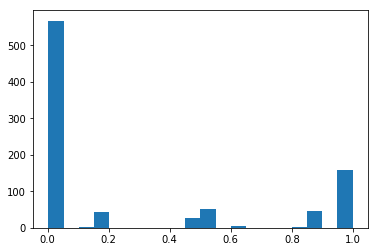

In [21]:
plt.hist(train_marginals, bins=20)
plt.show()

In [22]:
learned_table = gen_model.learned_lf_stats()
complete_stats = pd.DataFrame(np.hstack((learned_table.as_matrix()[:,0:2], stats_table.as_matrix()[:,[1,0]])), 
                              index = [i.__name__ for i in L_names], 
                              columns=['Learn. Acc.', 'Learn. Cov.', 'Emp. Acc.', 'Emp. Cov.'])
complete_stats

/Users/vinchen/miniconda3/envs/snorkel/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,Learn. Acc.,Learn. Cov.,Emp. Acc.,Emp. Cov.
LF_street,0.857026,0.7351,0.663342,0.444075
LF_vehicles,0.854854,0.7365,0.680798,0.444075
LF_distance,0.879654,0.7520,0.747273,0.609081
LF_size,0.879799,0.7579,0.770270,0.573643
LF_number,0.883487,0.7570,0.690513,0.712071


In [23]:
labels = 2 * (train_marginals > 0.9) - 1
print ('Coverage of Generative Model on Train Set:', np.sum(train_marginals != 0.5)/float(len(train_marginals)))
print ('Accuracy of Generative Model on Train Set:', np.mean(labels == loader.train_ground))

Coverage of Generative Model on Train Set: 1.0
Accuracy of Generative Model on Train Set: 0.74861572536
